In [20]:
%pwd

'/Users/colleenmccamy/Documents/MEDS/classes/spring'

### Part 1

1.	Yes, there already is an index and it is sqlite_autoindex_Bird_nests_1 SQLite will not use the automatically created index with the query above because the query filters columns (within the WHERE clause) not included within the index.

2.	Adding an index on a column not mentioned in the WHERE clause will not be used to query the database because it would be not be an efficient way to query the information given that the query will be using the information within the WHERE clause to identify the Nest_ID. Thus, if the index is for items outside of the WHERE clause it would not be relevant.

In [24]:
%cd eds-213-data-management

/Users/colleenmccamy/Documents/MEDS/classes/spring/eds-213-data-management


In [36]:
# importing libraries
import sqlite3
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# creating a connection
conn = sqlite3.connect("database-long-wide.db")
c = conn.cursor()


In [26]:
# defining the query for species data
species_query = """
   SELECT Nest_ID
    FROM Bird_nests
    WHERE Site = 'nome' AND
          Species = 'ruff' AND
          Year = 1983 AND
          Observer = 'cbishop' AND
          ageMethod = 'float';
"""

In [40]:
# establishing index columns to test
columns = [
    'Site',
    'Species',
    'Year',
    'Observer',
    'ageMethod',
    ['Observer', 'Species'],
    ['Year', 'ageMethod', 'Observer'],
    ['Species', 'ageMethod'],
    ['Observer', 'ageMethod', 'Year', 'Species'],
    ['Observer', 'Species', 'Year']
]

# creating a dataframe to store the results
results = pd.DataFrame(columns=['label', 'query_time', 'distinct_values'])

# creating a function to run the index timing tests
def run_index_test(label, index_column=None):
    if index_column:
        if isinstance(index_column, list):  
            index_column_str = ', '.join(index_column)
        else:
            index_column_str = index_column
            # creating index on Bird_nests table using the index_column
        cursor.execute(f'CREATE INDEX idx_{label} ON Bird_nests ({index_column_str})')

    start_time = timeit.default_timer()
    cursor.execute(query)
    # executing the query while timing how long it takes

    query_time = timeit.default_timer() - start_time

    if index_column:
        if isinstance(index_column, list):  
            # counting distinct rows if index_column is a list
            distinct_values = cursor.execute(
                f'SELECT COUNT(*) FROM (SELECT DISTINCT {index_column_str} FROM Bird_nests)'
            ).fetchone()[0]
        else:
            distinct_values = cursor.execute(
                f'SELECT COUNT(DISTINCT {index_column_str}) FROM Bird_nests'
            ).fetchone()[0]

            # dropping the index after getting the values
        cursor.execute(f'DROP INDEX idx_{label}')
    else:
        distinct_values = 1

    return [label, query_time, distinct_values]


# running the index tests
results.loc[0] =  run_index_test('no_index')

index = 1  # initializing the index for the index to index the indexes 

for col in columns:
    if isinstance(col, list):  # if col is a list, joining with underscore for label
        label = 'index_' + '_'.join(col)
    else:
        label = 'index_' + col
    results.loc[index] =  run_index_test(label, col)
    index += 1  # Increment the index variable

results.to_csv('index_timing.csv', index=False)


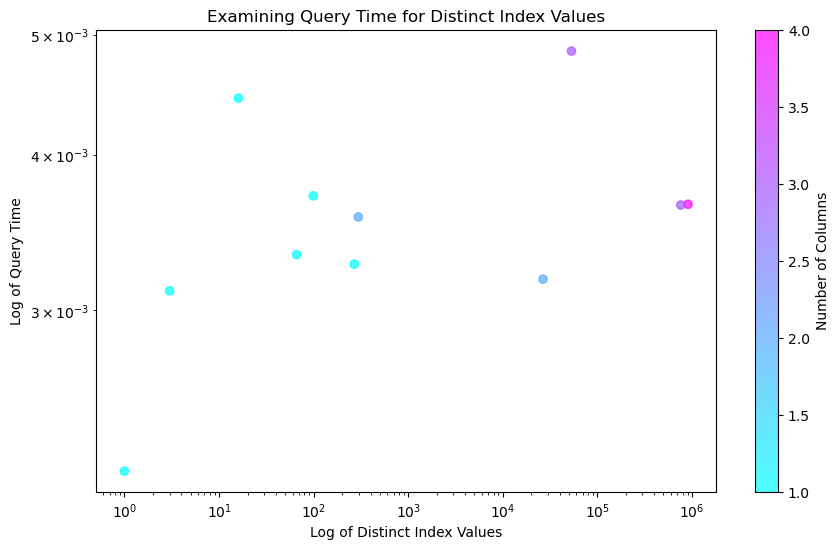

<Figure size 640x480 with 0 Axes>

In [47]:

# reading the the CSV file into a DataFrame
data = results

# extracting relevant columns
distinct_values = data['distinct_values']
query_time = data['query_time']
num_columns = [len(label.split('_')[1:]) for label in labels]  # Get the number of columns used in the index

# creating the colormap
cmap = plt.cm.get_cmap('cool')  # Choose a colormap

# creating a log-log scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(distinct_values, query_time, c = num_columns, cmap = cmap, alpha = 0.7)


# setting plot title and labels
plt.title('Examining Query Time for Distinct Index Values')
plt.xlabel('Log of Distinct Index Values')
plt.ylabel('Log of Query Time')

# setting logarithmic scale on both axes
plt.xscale('log')
plt.yscale('log')

# adding colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Number of Columns')

# adjusting plot margins
plt.margins(0.05)

# Show the plot
plt.show()

plt.savefig('index_timing_plot.png', dpi=300, bbox_inches='tight')


### Examining the Plot
From this plot, you can see that indexes with the higher number of columns have a higher log computational time. This is also correlated with an index of higher log of distinct values having a higher log computational time to execute. I think this is because as you are creating more disinct values it takes a lot longer to query through and use the index to find those distinct values.